**EXPERIMENT TO BUILD MEMNET USING ORIGINAL QUESTIONS AND WITH USING WIKICAP OPTIONS**

In [2]:
import matplotlib
#import tensorflow as tf
matplotlib.use('Agg')
#import matplotlib.pyplot as plt
#from matplotlib import rc
import pandas as pd

from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers import Embedding
from keras.layers import add, concatenate, dot, multiply
from keras.layers import LSTM,GRU
from keras.models import Model
#from keras.preprocessing.sequences import pad_sequences
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import collections
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.utils.vis_utils import plot_model
import keras.backend as K
import nltk
#import tensorflow as tf
#import time
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences

import json
import pandas as pd

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# Opening JSON file
f = open("/content/drive/MyDrive/IIITH/CVProject/dataset.json")
# converting csv file to data frame
data_frame = pd.read_csv("/content/drive/MyDrive/IIITH/CVProject/KGfacts-CloseWorld.csv",
                         names=['Qid', 'fact', 'factvalue', 'col4', 'col5'])
data = json.load(f)


In [5]:
train_image = []
train_image_Qids = []
test_image = []
test_image_Qids = []
for i in data:
  #print(i)  
  Qids = data[i]['Qids']
  exists_in_train=True
  for Qid in Qids:
    if any(Qid in sublist for sublist in train_image_Qids):
      continue
    else:
      exists_in_train=False
      break
  if ( exists_in_train==True):
    if (len(test_image)<100 ):
      test_image.append(i)
      test_image_Qids.append(Qids)
  else:
    if (len(train_image)<500):
      train_image.append(i)
      train_image_Qids.append(Qids)



print(len(train_image))
print(len(test_image))


500
100


In [6]:
data_frame.count()

Qid          174008
fact         174007
factvalue    173807
col4            680
col5             13
dtype: int64

In [7]:
def createType1Story(Qid, imageid, name, pos, total):
    return str(imageid) + '|' + Qid + '|' + name + ' is at position ' + str(pos) + ' of ' + str(total)

def createType2Story(imageid, wikiCap):
    return imageid + '|' + '|'  + wikiCap

def createType3Story(Qid, imageid, name1 , data_frame ):
    df = data_frame.loc[data_frame['Qid'] == Qid]
    type3stories = []
    for ind in df.index:
        type3stories.append(str(imageid) + '|' + Qid + '|' + str(name1)  + " "  + df['fact'][ind]  + " " + str(df['factvalue'][ind]) ) # \
        #+ " " + df['col4'][ind]) # + " " + df['col5'][ind]
    return type3stories

def createType1QA(imageid, question, answer):
    return str(imageid) + '| |' + question + '|' + str(answer)



In [8]:
def createStoriesQA(imageid, data):
    Qids = data[imageid]['Qids']
    questions_list = data[imageid]['Questions']
    answers_list = data[imageid]['Answers']
    wikiCap = data[imageid]['wikiCap']
    NamedEntities = data[imageid]['NamedEntities']
    paraQuestions_list = data[imageid]['ParaQuestions']
    storyitems = []

    # Create story items / knowledge base items
    for Qid, name in zip(Qids, NamedEntities):
        pos = Qids.index(Qid) + 1
        total = len(Qids)
        storyitems1 = createType1Story(Qid, imageid, name, pos, total)
        storyitems.append(storyitems1)
        storyitems2 = createType2Story(imageid, wikiCap)
        storyitems.append(storyitems2)
        storyitems3 = createType3Story(Qid, imageid, name, data_frame)
        storyitems.extend(storyitems3)

    qaitems = []
    for question, answer in zip(questions_list, answers_list):
        qaitem = createType1QA(imageid, question, answer)
        qaitems.append(qaitem)

#    print(len(qaitems))
    return storyitems, qaitems

**TRAIN DATA**

In [9]:
train_imageid_list=[]
# Iterating through the json
count = 0
train_storyitems_list=[]
train_qaitems_list = []
for i in train_image:
  train_imageid_list.append(i)
  train_storyitems, train_qaitems = createStoriesQA(i, data)
  train_storyitems_list.append(train_storyitems)
  train_qaitems_list.append(train_qaitems)
print(train_storyitems_list[0])
print(train_qaitems_list[0])
print(len(train_storyitems_list))
print(len(train_qaitems_list))

['21717|Q1441444|Francis Condon is at position 1 of 1', '21717||Francis Condon in the early 20th Century', '21717|Q1441444|Francis Condon alma mater Georgetown University Law Center', '21717|Q1441444|Francis Condon date of birth 1891-11-11', '21717|Q1441444|Francis Condon date of death 23-11-1965', '21717|Q1441444|Francis Condon is member of Democratic Party', '21717|Q1441444|Francis Condon knows language English', '21717|Q1441444|Francis Condon occupation judge', '21717|Q1441444|Francis Condon occupation lawyer', '21717|Q1441444|Francis Condon occupation politician', '21717|Q1441444|Francis Condon place of birth Central Falls', '21717|Q1441444|Francis Condon place of death Boston', '21717|Q1441444|Francis Condon sex male']
['21717| |Who is the person in the image?|Francis Condon', '21717| |For how many years did the person in the image live?|74', '21717| |Was the person in the image born after the end of World War II?|No', '21717| |In which country was the person in the image born?|Un

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**TEST DATA**

In [10]:
test_imageid_list=[]
# Iterating through the json
count = 0
test_storyitems_list=[]
test_qaitems_list = []
for i in test_image:
  test_imageid_list.append(i)
  test_storyitems, test_qaitems = createStoriesQA(i, data)
  test_storyitems_list.append(test_storyitems)
  test_qaitems_list.append(test_qaitems)
print(test_storyitems_list[0])
print(test_qaitems_list[0])
print(len(test_storyitems_list))
print(len(test_qaitems_list))

['33992|Q40531|John Wayne is at position 1 of 1', '33992||John Wayne as "Singin\' Sandy" Saunders in Riders of Destiny (1933)', '33992|Q40531|John Wayne alma mater University of Southern California', '33992|Q40531|John Wayne date of birth 1907-05-26', '33992|Q40531|John Wayne date of death 1979-06-11', '33992|Q40531|John Wayne is member of Republican Party', '33992|Q40531|John Wayne knows language English', '33992|Q40531|John Wayne occupation actor', '33992|Q40531|John Wayne occupation American football player', '33992|Q40531|John Wayne occupation film actor', '33992|Q40531|John Wayne occupation film director', '33992|Q40531|John Wayne occupation film producer', '33992|Q40531|John Wayne occupation screenwriter', '33992|Q40531|John Wayne place of birth Winterset', '33992|Q40531|John Wayne place of death Los Angeles', '33992|Q40531|John Wayne sex male', '33992|Q40531|John Wayne spouse Esperanza Baur', '33992|Q40531|John Wayne spouse Josephine Wayne', '33992|Q40531|John Wayne spouse Pilar

In [11]:
def get_data_new(storyitems_list, qaitems_list):
    imageids ,stories, questions, answers = [],[],[],[]

    #get the stories for each image
    for storyitems in storyitems_list:
      storylst = []
      for story in storyitems:
        story_list = story.split("|")
        #print(story_list)
        story_text = story_list[2]
        #print('story text' , story_text)
        imageid = story_list[0]
        storylst.append(story_text)
      imageids.append(imageid)
      stories.append(storylst)

    for qaitems in qaitems_list:
      questionlst = []
      answerlst = []
      for qa in qaitems:
        qalist = qa.split("|")
        question = qalist[2]
        answer = qalist[3]
        imageid = qalist[0]
        questionlst.append(question)
        answerlst.append(answer)
      questions.append(questionlst)
      answers.append(answerlst)

    return imageids, stories, questions, answers


In [12]:
def build_vocab_new(stories, questions, answers):
    counter = collections.Counter()
    answer_counter = collections.Counter()
    #for stories, questions, answers in [train_data, test_data]:
    for story in stories:
      for sent in story:
        for word in nltk.word_tokenize(sent):
          counter[word.lower()] += 1
    for questionlist in questions:
      for question in questionlist:
        for word in nltk.word_tokenize(question):
          counter[word.lower()] +=1
    for answerlist in answers:
      for answer in answerlist:
        for word in nltk.word_tokenize(answer):
          word=answer
          counter[word.lower()] += 1
          answer_counter[word.lower()] += 1
    word2idx = {w: (i + 1) for i, (w, _) in enumerate(counter.most_common())}
    print(word2idx)
    word2idx['PAD'] = 0
    idx2word = {v: k for k, v in word2idx.items()}

    word2idx_a = {w: (i + 1) for i, (w, _) in enumerate(answer_counter.most_common())}
    print(word2idx_a)
    word2idx_a['PAD'] = 0
    idx2word_a = {v: k for k, v in word2idx_a.items()}

    return word2idx, idx2word, word2idx_a, idx2word_a

In [13]:
def get_maxlens_new(stories, questions):
    story_maxlen, question_maxlen = 0, 0
    story_max = ""
    question_max = ""
#    for stories, questions, _ in [train_data, test_data]:
    for story in stories:
      story_len = 0
      for sent in story:
        story_len += len(nltk.word_tokenize(sent))
        if (story_len > story_maxlen):
          story_max = story
          story_maxlen = max(story_len, story_maxlen)
    for questionlist in questions:
      for question in questionlist:
        question_len = len(nltk.word_tokenize(question))
        if (question_len > question_maxlen):
          question_max = question
          question_maxlen = max(question_len, question_maxlen)

    return story_maxlen, question_maxlen, story_max, question_max


In [14]:
def vectorize_new(stories, questions, answers, word2idx, story_maxlen, question_maxlen):
    X_story, X_question, Y = [], [], []
    #stories, questions, answers = data
    print(len(stories))
    print(len(questions))
    print(len(answers))
    count1 = 0
    for story, question_list, answer_list in zip(stories, questions, answers):
      count1 = count1 + 1
      count2 = 0
#      print('inside outer loop')
      for question, answer in zip(question_list, answer_list):
        if (answer.strip() == ''):
          break
        count2 = count2+1
#        print('inside inner loop')
        X_s = [[word2idx[w.lower()] for w in nltk.word_tokenize(s)] for s in story]
        X_s = list(itertools.chain.from_iterable(X_s))
        X_q = [word2idx[w.lower()] for w in nltk.word_tokenize(question)]
#        Y_a = [word2idx[w.lower()] for w in nltk.word_tokenize(answer)]
        X_story.append(X_s)
        X_question.append(X_q)
#        Y.append(Y_a)
#        print('c1 :', count1, 'c2 : ', count2)
        Y.append(word2idx[answer.lower()])

    return pad_sequences(X_story, maxlen=story_maxlen),pad_sequences(X_question, maxlen=question_maxlen), np_utils.to_categorical(Y, num_classes=len(word2idx))



# PREPARE DATA FOR TRAINING THE MODEL

In [15]:
DATA_DIR = './'
MODEL_DIR='./'

In [16]:
print(train_storyitems_list + test_storyitems_list)


[['21717|Q1441444|Francis Condon is at position 1 of 1', '21717||Francis Condon in the early 20th Century', '21717|Q1441444|Francis Condon alma mater Georgetown University Law Center', '21717|Q1441444|Francis Condon date of birth 1891-11-11', '21717|Q1441444|Francis Condon date of death 23-11-1965', '21717|Q1441444|Francis Condon is member of Democratic Party', '21717|Q1441444|Francis Condon knows language English', '21717|Q1441444|Francis Condon occupation judge', '21717|Q1441444|Francis Condon occupation lawyer', '21717|Q1441444|Francis Condon occupation politician', '21717|Q1441444|Francis Condon place of birth Central Falls', '21717|Q1441444|Francis Condon place of death Boston', '21717|Q1441444|Francis Condon sex male'], ['24345|Q331838|Michael Steele is at position 1 of 1', '24345||Michael Steele in June 2016.', '24345|Q331838|Michael Steele alma mater Georgetown University Law Center', '24345|Q331838|Michael Steele alma mater Johns Hopkins University', '24345|Q331838|Michael Ste

In [17]:
imageids, stories, questions, answers = get_data_new(train_storyitems_list + test_storyitems_list, train_qaitems_list + test_qaitems_list)
print(imageids[0])
print(stories[0])
print(questions[0])
print(answers[0])

word2idx, idx2word, word2idx_a, idx2word_a = build_vocab_new(stories, questions, answers)
print(len(word2idx))
print(len(idx2word))
print(len(word2idx_a))
print(len(idx2word_a))

vocab_size = len(word2idx)

story_maxlen, question_maxlen, story_max, question_max = get_maxlens_new(stories, questions)
print('story len', story_maxlen)
print('question len', question_maxlen)
print('story max ', story_max)
print('question_max ', question_max)



21717
['Francis Condon is at position 1 of 1', 'Francis Condon in the early 20th Century', 'Francis Condon alma mater Georgetown University Law Center', 'Francis Condon date of birth 1891-11-11', 'Francis Condon date of death 23-11-1965', 'Francis Condon is member of Democratic Party', 'Francis Condon knows language English', 'Francis Condon occupation judge', 'Francis Condon occupation lawyer', 'Francis Condon occupation politician', 'Francis Condon place of birth Central Falls', 'Francis Condon place of death Boston', 'Francis Condon sex male']
['Who is the person in the image?', 'For how many years did the person in the image live?', 'Was the person in the image born after the end of World War II?', 'In which country was the person in the image born?', 'In which continent was the person in the image born?', 'How many political parties has the person in the image been a part of?', 'Who is the founder of the political party to which person in the image belongs to?', 'Is the person in 

In [18]:
print('story len', len(questions))
print(len( test_storyitems_list))

story len 600
100


In [19]:
split_num=500
stories_train, questions_train, answers_train = vectorize_new(stories[:split_num], questions[:split_num], answers[:split_num], word2idx, story_maxlen, question_maxlen)
stories_test, questions_test, answers_test = vectorize_new(stories[split_num:], questions[split_num:], answers[split_num:], word2idx, story_maxlen, question_maxlen)



500
500
500
100
100
100


In [20]:
print(len(stories))
print(len(questions))
print(len(answers))

#print(stories_test[0])
print(questions_test[0])
print(len(answers_test[0]))

600
600
600
[ 0  0  0  0  0  0  0  0  0  0 12  7  1  6  2  1  5  4]
6147


In [21]:
    vocab_size = len(word2idx)
    EMBEDDING_SIZE = story_maxlen
    LATENT_SIZE = 32
    DATA_DIR = './'
    MODEL_DIR='./'



**BUILD THE MODEL**

In [22]:
    print("Building model...")
    story_input = Input(shape=(story_maxlen,))
    question_input = Input(shape=(question_maxlen,))
    
    #####
    story_encoder = Embedding(input_dim=vocab_size,output_dim=EMBEDDING_SIZE,input_length=story_maxlen)(story_input)
    story_encoder = Dropout(0.3)(story_encoder, training=True)
    print(story_encoder.shape)
    story_encoder = GRU(story_maxlen, input_shape=(story_maxlen,EMBEDDING_SIZE),activation='sigmoid', return_sequences=True)(story_encoder)
    story_encoder = GRU(story_maxlen, input_shape=(story_maxlen,EMBEDDING_SIZE),activation='sigmoid', return_sequences=True, go_backwards=True)(story_encoder)
    print(story_encoder.shape)
    story_encoder = Permute((2,1))(story_encoder)
    print(story_encoder.shape)

    question_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE, input_length=question_maxlen)(question_input)
    question_encoder = Dropout(0.3)(question_encoder , training=True)
    question_encoder = GRU(EMBEDDING_SIZE, input_shape=(vocab_size, EMBEDDING_SIZE),activation='sigmoid', return_sequences=True)(question_encoder)
    question_encoder = GRU(EMBEDDING_SIZE, input_shape=(vocab_size, EMBEDDING_SIZE),activation='sigmoid', return_sequences=True, go_backwards=True)(question_encoder)

    match = dot([story_encoder, question_encoder], axes=[2,2])
    match = Activation('softmax')(match)

    story_encoder_c = Embedding(input_dim=vocab_size,output_dim=question_maxlen,input_length=story_maxlen)(story_input)
    story_encoder_c = Dropout(0.3)(story_encoder_c, training=True)
    story_encoder_c = GRU(question_maxlen, input_shape=(story_maxlen,question_maxlen),activation='sigmoid', return_sequences=True)(story_encoder_c)
    story_encoder_c = GRU(question_maxlen, input_shape=(story_maxlen,question_maxlen),activation='sigmoid', return_sequences=True, go_backwards=True)(story_encoder_c)

    #response = multiply([match, story_encoder_c])
    response = add([match, story_encoder_c])
    response = Permute((2,1))(response)
    ####
    print("first done")


Building model...


(None, 610, 610)


(None, 610, 610)
(None, 610, 610)


first done


In [23]:
    story_encoder = Permute((2,1))(story_encoder)
    print(story_encoder.shape)
    match = dot([response, story_encoder], axes=[2,2])
    match = Activation('softmax')(match)
    print(match.shape)
    match = Permute((2,1))(match)
    print(match.shape)
    #response = multiply([match, story_encoder_c])
    response = add([match, story_encoder_c])
    print(response.shape)
    response = Permute((2,1))(response)
    ###
    print("first done")
    story_encoder = Permute((2,1))(story_encoder)
    print(story_encoder.shape)
    match = dot([response, story_encoder], axes=[2,2])
    match = Activation('softmax')(match)
    print(match.shape)
    match = Permute((2,1))(match)
    print(match.shape)
    #response = multiply([match, story_encoder_c])
    response = add([match, story_encoder_c])
    print(response.shape)
    response = Permute((2,1))(response)
    #match = dot([story_encoder, response], axes=[2,2])
    #response = add([match, story_encoder_c])
    ###
    #response = Permute((2,1))(response)

    

    answer = concatenate([response, question_encoder], axis=-1)
    answer = LSTM(LATENT_SIZE)(answer)
    answer = Dropout(0.3)(answer, training=True)
    answer = Dense(len(word2idx))(answer)
    output = Activation('softmax')(answer)
    
    model = Model(inputs=[story_input, question_input], outputs=output)
#    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

(None, 610, 610)
(None, 18, 610)
(None, 610, 18)
(None, 610, 18)
first done
(None, 610, 610)
(None, 18, 610)
(None, 610, 18)
(None, 610, 18)


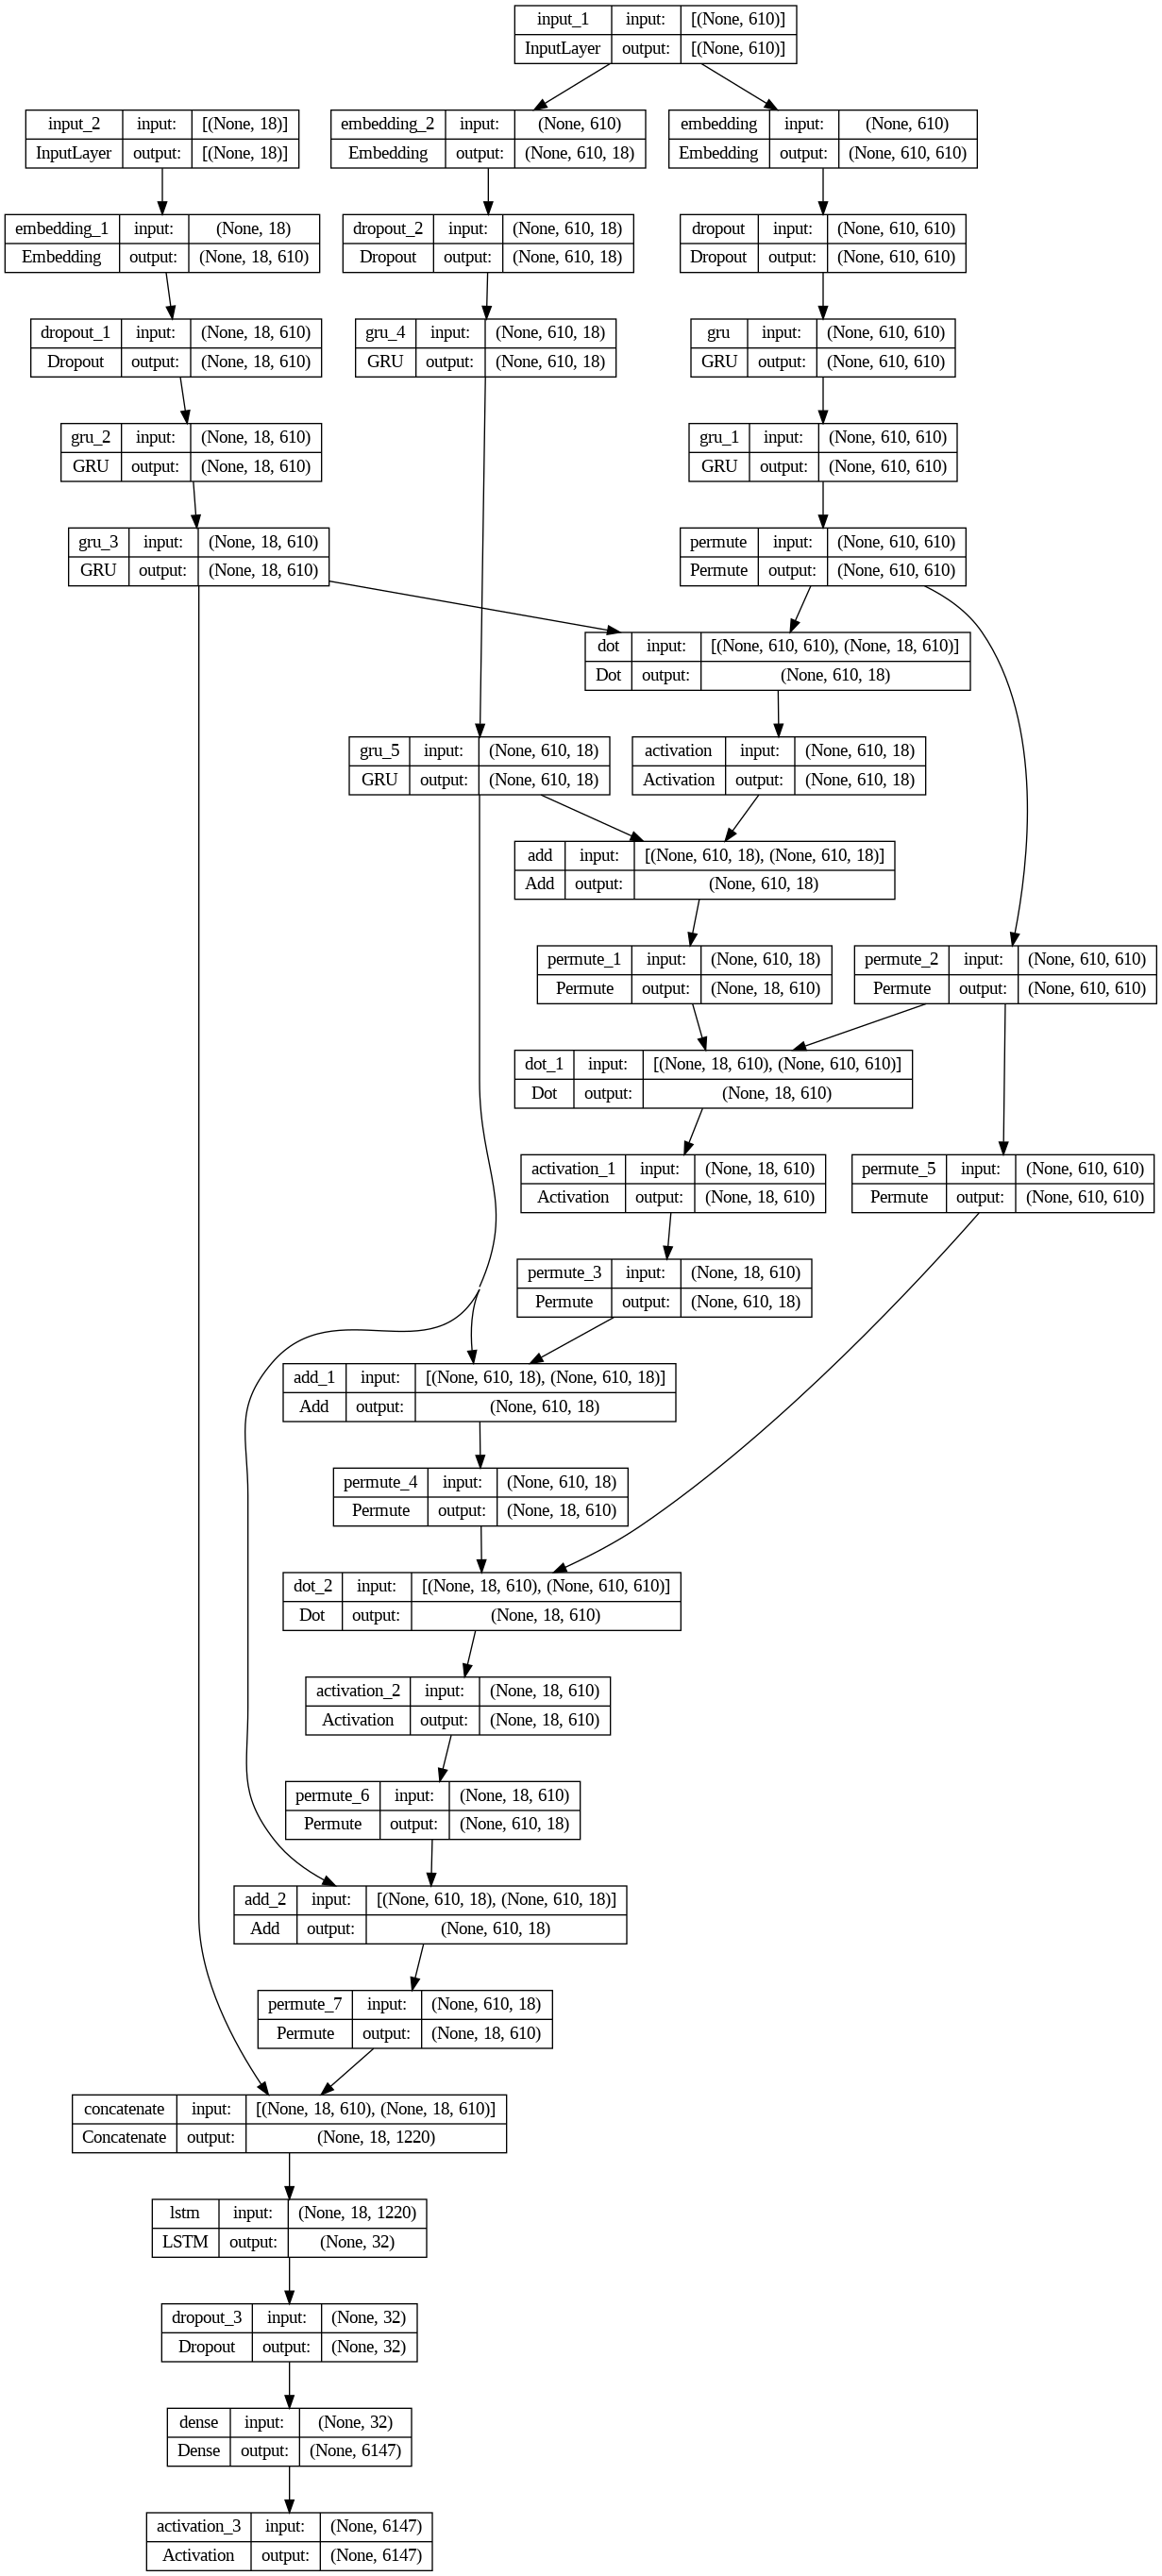

In [24]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [25]:
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    BATCH_SIZE = 64
    NUM_EPOCHS = 25
    print("training...")
    inp=model.input
    outputs = [layer.output for layer in model.layers]
#    functor = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]
    test = np.random.random([vocab_size,EMBEDDING_SIZE])[np.newaxis,...]
#    print(functor)
    checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR,"qa-memnn-best.hdf5"), verbose=1, save_best_only=True)

    history = model.fit([stories_train, questions_train], [answers_train],batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=([stories_test, questions_test], [answers_test]))


training...
Epoch 1/25
60/60 [==============================] - 411s 6s/step - loss: 6.1142 - categorical_accuracy: 0.1455 - val_loss: 4.9145 - val_categorical_accuracy: 0.1765
Epoch 2/25
60/60 [==============================] - 379s 6s/step - loss: 4.9795 - categorical_accuracy: 0.1557 - val_loss: 4.8049 - val_categorical_accuracy: 0.1087
Epoch 3/25
60/60 [==============================] - 371s 6s/step - loss: 4.8823 - categorical_accuracy: 0.1557 - val_loss: 4.7139 - val_categorical_accuracy: 0.1765
Epoch 4/25
60/60 [==============================] - 375s 6s/step - loss: 4.8175 - categorical_accuracy: 0.1523 - val_loss: 4.6924 - val_categorical_accuracy: 0.1765
Epoch 5/25
60/60 [==============================] - 371s 6s/step - loss: 4.8012 - categorical_accuracy: 0.1602 - val_loss: 4.7328 - val_categorical_accuracy: 0.1714
Epoch 6/25
60/60 [==============================] - 378s 6s/step - loss: 4.8110 - categorical_accuracy: 0.1563 - val_loss: 4.6876 - val_categorical_accuracy: 0.176

Evaluation...
13/13 [==============================] - 6s 500ms/step - loss: 4.6714 - categorical_accuracy: 0.1253
Test loss/accuracy final model = 4.6714, 0.1253
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 610)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 610, 610)     3749670     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dropout (Dropout)            

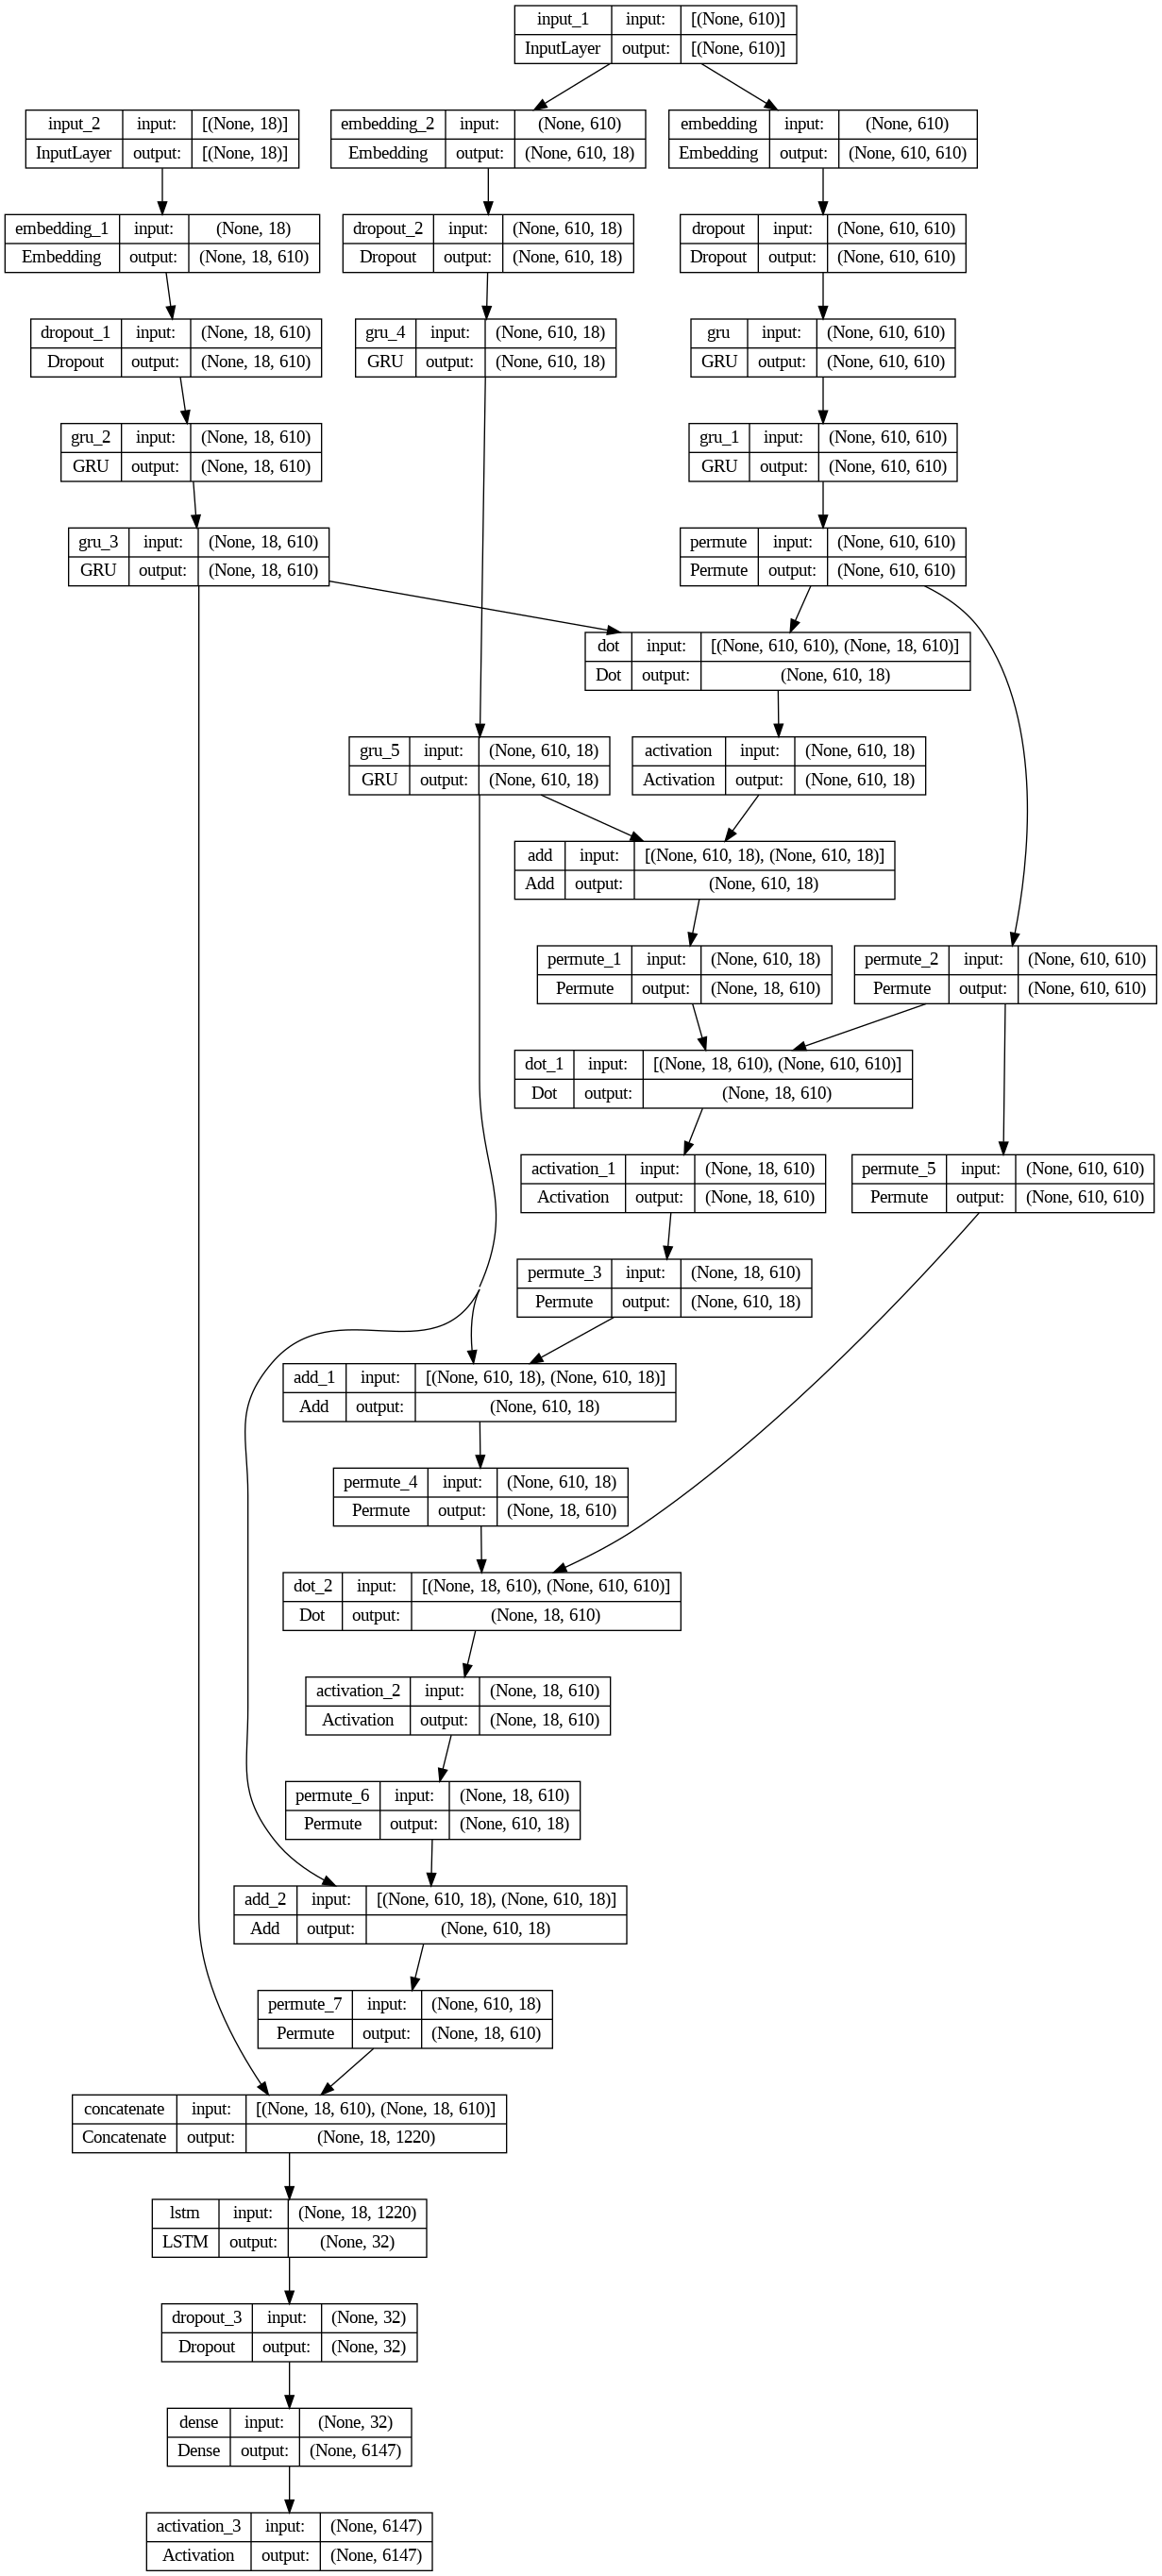

In [26]:
    plt.figure()
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.savefig('/content/drive/MyDrive/IIITH/CVProject/graphs/accuracyw.png', bbox_inches='tight')

    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.savefig('/content/drive/MyDrive/IIITH/CVProject/graphs/lossw.png', bbox_inches='tight')
   
    print("Evaluation...")
    loss, acc = model.evaluate([stories_test, questions_test], [answers_test], batch_size=BATCH_SIZE)
    print("Test loss/accuracy final model = %.4f, %.4f" % (loss,acc))

#    model.save_weights(os.path.join(MODEL_DIR,"qa-memnn-final.hdf5"))
#    with open(os.path.join(MODEL_DIR,"qa-memnn.json"),"wb") as fjson:
#        fjson.write(model.to_json())
#    model.load_weights(filepath=os.path.join(MODEL_DIR, "qa-memnn-best.hdf5"))
#    loss, acc = model.evaluate([X_story_test, X_question_test], [Y_test], batch_size=BATCH_SIZE)
#    print("Test loss/accuracy best model = %.4f, %.4f" % (loss, acc))
    print(model.summary())
    plot_model(model, to_file='/content/drive/MyDrive/IIITH/CVProject/graphs/model_plotw.png', show_shapes=True, show_layer_names=True)
